In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', 0)
os.getcwd()

'/Users/beth/Documents/Repositories/Kaggle/HousingPrices'

In [2]:
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')

Removing some variables based on previous notebook

In [3]:
train.drop('Id',axis=1,inplace=True)
#remove variables based on correlation < 0.2 or > -0.2 with sale price
train.drop(['BsmtUnfSF','ScreenPorch','MoSold','3SsnPorch','PoolArea','MSSubClass','BsmtHalfBath','YrSold','BsmtFinSF2','MiscVal','LowQualFinSF','OverallCond','KitchenAbvGr'],axis=1,inplace=True)
#remove variables based on > 0.05 ANOVA p-val with sale price
train.drop(['MiscFeature','Street','LandSlope','PoolQC','Utilities','Condition2'],axis=1,inplace=True)

Ordinally encoding some the Quality and Condition variables

In [4]:
def ordinal_encode(x,values=['Po','Fa','TA','Gd','Ex']):
    values = np.asarray(values).reshape(-1,1)
    encoder = OrdinalEncoder()
    temp = encoder.fit(values)
    train[[x]]=np.where(train[[x]].isna(),'TA',train[[x]])
    result = encoder.transform(train[[x]])
    return(pd.Series(result.flatten()))

In [5]:
train['ExterQual'] = ordinal_encode('ExterQual')
train['ExterCond'] = ordinal_encode('ExterCond',['Po','Fa','TA','Gd','Ex'])
train['BsmtQual'] = ordinal_encode('BsmtQual',['Po','Fa','TA','Gd','Ex'])
train['BsmtCond'] = ordinal_encode('BsmtCond',['Po','Fa','TA','Gd','Ex'])
train['HeatingQC'] = ordinal_encode('HeatingQC',['Po','Fa','TA','Gd','Ex'])
train['KitchenQual'] = ordinal_encode('KitchenQual',['Po','Fa','TA','Gd','Ex'])
train['FireplaceQu'] = ordinal_encode('FireplaceQu',['Po','Fa','TA','Gd','Ex'])
train['GarageQual'] = ordinal_encode('GarageQual',['Po','Fa','TA','Gd','Ex'])
train['GarageCond'] = ordinal_encode('GarageCond',['Po','Fa','TA','Gd','Ex'])

Looking at columns with NA

In [12]:
train.loc[:,train.isna().any()].dtypes

LotFrontage     float64
Alley           object 
MasVnrType      object 
MasVnrArea      float64
BsmtExposure    object 
BsmtFinType1    object 
BsmtFinType2    object 
Electrical      object 
GarageType      object 
GarageYrBlt     float64
GarageFinish    object 
Fence           object 
dtype: object

Imputing values for float64 columns with NA using the columns mean

In [13]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train[['LotFrontage','GarageYrBlt','MasVnrArea']] = imp_mean.fit_transform(train[['LotFrontage','GarageYrBlt','MasVnrArea']])

Scaling the numeric (and non-ordinal) columns (not sure about this step)

In [17]:
ss = StandardScaler()
num_scaled = ss.fit_transform(train[['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch']])

In [18]:
num_scaled = pd.DataFrame(num_scaled,columns=['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch'])

Getting the log of the SalePrice as a target

In [16]:
train['logSalePrice']=np.log(train['SalePrice'])

Plotting some of the numeric non-ordinal columns vs logSalePrice, and trying to remove effects of outliers or focus in on linear ranges

Not sure if this is necessary

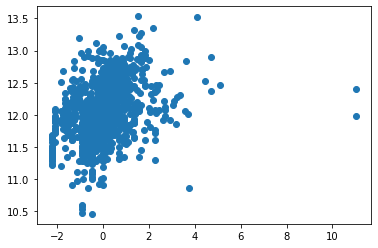

In [19]:
plt.scatter(x=num_scaled['LotFrontage'],y=train['logSalePrice'])

In [20]:
num_scaled['LotFrontage'] = (num_scaled['LotFrontage']<6).astype(int)*num_scaled['LotFrontage']

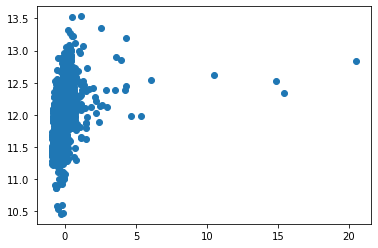

In [21]:
plt.scatter(x=num_scaled['LotArea'],y=train['logSalePrice'])

In [22]:
num_scaled['LotArea'] = (num_scaled['LotArea']<5).astype(int)*num_scaled['LotArea']

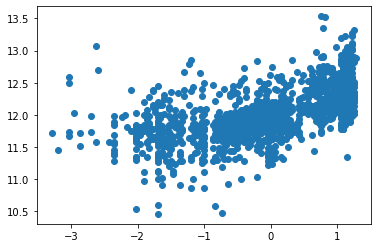

In [23]:
plt.scatter(x=num_scaled['YearBuilt'],y=train['logSalePrice'])

In [24]:
num_scaled['YearBuilt'] = (num_scaled['YearBuilt']>-1).astype(int)*num_scaled['YearBuilt']

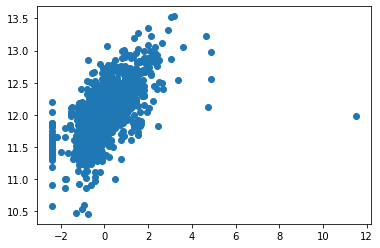

In [25]:
plt.scatter(x=num_scaled['TotalBsmtSF'],y=train['logSalePrice'])

In [26]:
num_scaled['TotalBsmtSF'] = (num_scaled['TotalBsmtSF']<4).astype(int)*num_scaled['TotalBsmtSF']

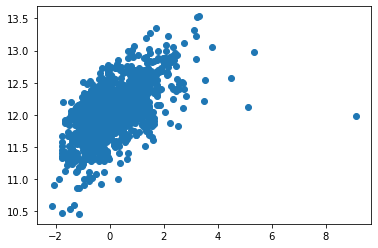

In [27]:
plt.scatter(x=num_scaled['1stFlrSF'],y=train['logSalePrice'])

In [28]:
num_scaled['1stFlrSF'] = (num_scaled['1stFlrSF']<4).astype(int)*num_scaled['1stFlrSF']

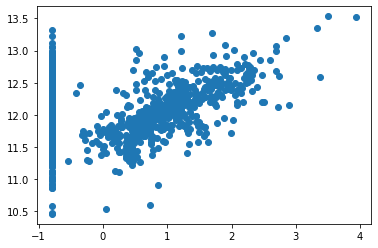

In [29]:
plt.scatter(x=num_scaled['2ndFlrSF'],y=train['logSalePrice'])

In [30]:
num_scaled['No2ndFloor'] = (num_scaled['2ndFlrSF']==0).astype(int)

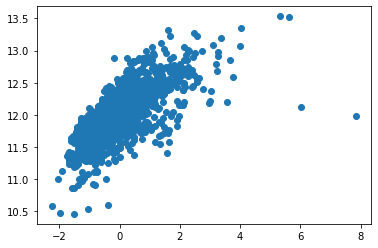

In [31]:
plt.scatter(x=num_scaled['GrLivArea'],y=train['logSalePrice'])

In [32]:
num_scaled['GrLivArea'] = (num_scaled['GrLivArea']<5).astype(int)*num_scaled['GrLivArea']

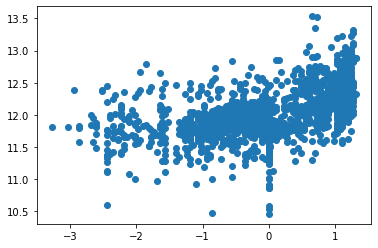

In [33]:
plt.scatter(x=num_scaled['GarageYrBlt'],y=train['logSalePrice'])

In [34]:
num_scaled['GarageYrBlt'] = (num_scaled['GarageYrBlt']>-1.25).astype(int)*num_scaled['GarageYrBlt']

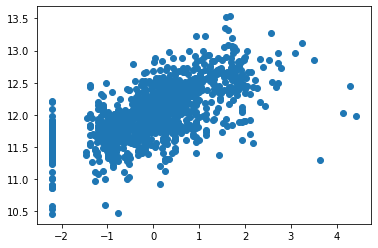

In [35]:
plt.scatter(x=num_scaled['GarageArea'],y=train['logSalePrice'])

In [36]:
num_scaled['GarageArea'] = (num_scaled['GarageArea']<3).astype(int)*num_scaled['GarageArea']

In [37]:
num_scaled['NoGarage'] = (num_scaled['GarageArea']==0).astype(int)

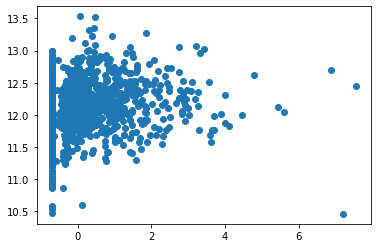

In [38]:
plt.scatter(x=num_scaled['OpenPorchSF'],y=train['logSalePrice'])

In [39]:
num_scaled['OpenPorchSF'] = (num_scaled['OpenPorchSF']<5).astype(int)*num_scaled['OpenPorchSF']

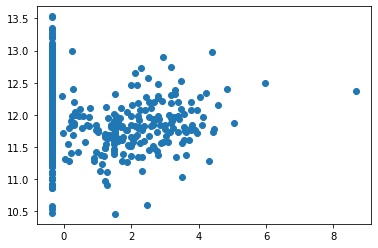

In [40]:
plt.scatter(x=num_scaled['EnclosedPorch'],y=train['logSalePrice'])

In [41]:
num_scaled['NoEnclosedPorch'] = (num_scaled['EnclosedPorch']==0).astype(int)

Using a cutoff for values of categorial predictors, and making those values under the cutoff count np.na

In [42]:
def count_over_value(x,column,cutoff):
    try:
        return(train[column].value_counts()[x]>cutoff)
    except:
        return(False)
    

In [43]:
#trying differnt cutoffs would be a good idea, I used 50
for col in train.select_dtypes(include=['object']).columns:
    train[col] = pd.Series(np.where(train[col].apply(count_over_value,column=col,cutoff=50),train[col],np.nan))

Creating one-hot-encoded columns for object values

In [45]:
train_dummies = train.select_dtypes(include=['object'])

for col in train_dummies.select_dtypes(include=['object']).columns:
    dummies = pd.get_dummies(train_dummies[col],prefix=col+'_')
    train_dummies = pd.concat([train_dummies, dummies],axis=1)
    train_dummies.drop([col],axis=1,inplace=True)

In [46]:
train_dummies.shape

(1460, 86)

Train final is the concatenation of the dummies, ordinal, and scaled numeric predictors

In [47]:
train_final_X = pd.concat([train_dummies,num_scaled,train[['ExterQual','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','OverallQual']]],axis=1)

In [48]:
train_final_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 112 entries, MSZoning__FV to OverallQual
dtypes: float64(22), int64(4), uint8(86)
memory usage: 419.3 KB


In [51]:
train_Y = train['logSalePrice']

Try first linear model with 10-fold cross val, get average RMSE

In [52]:
model = LinearRegression()
scores = cross_val_score(model, train_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-458677613.14530355

Not sure why this is such a large number

Look at a specific test/train split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train_final_X, train_Y, test_size=0.1,random_state=111)

In [54]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
results = pd.DataFrame(data={'actual':y_test,'predicted':model.predict(X_test)})

In [56]:
results

,actual,predicted
1035,11.338572,11.354736
922,12.043495,12.134155
952,11.804849,11.866089
788,11.588960,11.594971
536,12.144197,12.242920
...,...,...
670,12.063933,12.071289
385,12.165251,12.174927
94,12.229545,12.201782
185,13.071070,12.630737


In [57]:
np.sqrt(np.sum(np.square(results['actual']-results['predicted']))/results.shape[0])

0.13976865134284133

Not sure why this is so different?

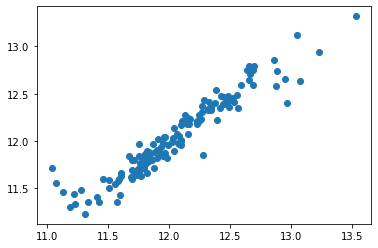

In [58]:
plt.scatter(x='actual',y='predicted',data=results)

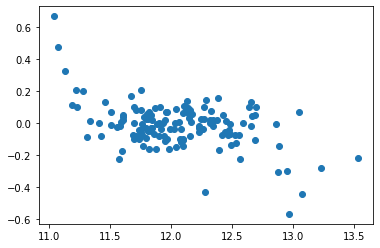

In [59]:
plt.scatter(x=results['actual'],y=results['predicted']-results['actual'])

From the shape of the residual we should transform some variables to be squared and/or cubed

In [60]:
pd.DataFrame(zip(train_final_X.columns, model.coef_)).sort_values(by=1)

,0,1
101,NoGarage,-1.363119e-01
39,Exterior1st__Wd Sdng,-1.038814e-01
61,BsmtFinType1__Unf,-9.619843e-02
35,Exterior1st__HdBoard,-8.358969e-02
59,BsmtFinType1__LwQ,-6.802306e-02
...,...,...
0,MSZoning__FV,1.494672e-01
102,NoEnclosedPorch,1.003991e+05
100,No2ndFloor,4.263006e+05
65,CentralAir__N,8.755629e+11


<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

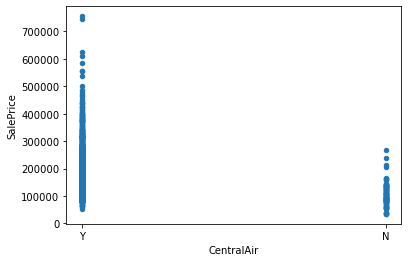

In [61]:
train.plot(x='CentralAir',y='SalePrice',kind='scatter')

This linear model is obviously bad because it has massive coefficients on Central Air Y and N. Really confusing

Get the squared, cubed terms for numeric non-ordinal columns only

In [62]:
squared_num_cols = np.square(train_final_X[['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch']])

In [63]:
cubed_num_cols = np.power(train_final_X[['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch']],3)

In [64]:
squared_num_cols.columns = squared_num_cols.columns + '_^2'

In [65]:
cubed_num_cols.columns = cubed_num_cols.columns + '_3'

Looking at interaction terms, using a Lasso model to select most informative ones

In [67]:
poly = PolynomialFeatures(2,interaction_only=True)
train_poly_X = poly.fit_transform(train_final_X)

In [69]:
model = Lasso(alpha=0.001,max_iter=5000,fit_intercept=True)
model.fit(train_poly_X, train_Y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [70]:
poly_names = poly.get_feature_names(train_final_X.columns)

In [71]:
coefs = pd.DataFrame(zip(poly_names, model.coef_)).sort_values(by=1)

In [72]:
coefs

,0,1
1751,Neighborhood__NAmes GrLivArea,-0.033266
6121,TotalBsmtSF GrLivArea,-0.017175
763,LandContour__Bnk OverallQual,-0.016702
3765,Exterior1st__Wd Sdng BsmtQual,-0.013484
4432,Foundation__BrkTil HeatingQC,-0.013063
...,...,...
5040,BsmtFinType1__Rec OpenPorchSF,0.018102
2569,BldgType__1Fam 2ndFlrSF,0.020153
4356,MasVnrType__Stone 1stFlrSF,0.023130
5817,Fence__GdWo GarageArea,0.023952


In [73]:
coefs[2]=np.absolute(coefs[1])

In [74]:
top_interactions = coefs[coefs[2]>0.01][0]

In [75]:
top_interactions

1751    Neighborhood__NAmes GrLivArea        
6121    TotalBsmtSF GrLivArea                
763     LandContour__Bnk OverallQual         
3765    Exterior1st__Wd Sdng BsmtQual        
4432    Foundation__BrkTil HeatingQC         
1754    Neighborhood__NAmes WoodDeckSF       
6126    TotalBsmtSF EnclosedPorch            
5100    BsmtFinType1__Unf FireplaceQu        
1575    Neighborhood__Edwards OverallQual    
2754    BldgType__TwnhsE KitchenQual         
6140    1stFlrSF GrLivArea                   
5290    CentralAir__N FireplaceQu            
2043    Neighborhood__OldTown BsmtQual       
6004    LotFrontage LotArea                  
3839    Exterior2nd__CmentBd KitchenQual     
311     MSZoning__RL YearRemodAdd            
650     LotShape__Reg BsmtQual               
2884    HouseStyle__1Story GarageType__Attchd
5506    GarageType__Attchd GarageQual        
6157    1stFlrSF OverallQual                 
4542    Foundation__PConc GarageYrBlt        
4293    MasVnrType__None 1stFlrSF 

In [76]:
train_poly_X = pd.DataFrame(train_poly_X,columns=poly_names)

train_poly_final has polynomial terms, top interaction terms, and other terms already existing

In [77]:
train_poly_final_X = pd.concat([squared_num_cols,cubed_num_cols,train_poly_X[top_interactions],train_final_X],axis=1)

In [161]:
train_poly_final_X.shape

(1460, 188)

In [154]:
model = LinearRegression()
scores = cross_val_score(model, train_poly_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.12398023700563539

In [162]:
X_train, X_test, y_train, y_test = train_test_split(train_poly_final_X, train_Y, test_size=0.1,random_state=111)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [163]:
results = pd.DataFrame(data={'actual':y_test,'predicted':model.predict(X_test)})

In [157]:
results

,actual,predicted
1035,11.338572,11.333818
922,12.043495,12.164232
952,11.804849,11.855183
788,11.588960,11.596255
536,12.144197,12.244493
...,...,...
670,12.063933,12.070003
385,12.165251,12.158386
94,12.229545,12.193185
185,13.071070,12.563074


In [158]:
np.sqrt(np.sum(np.square(results['actual']-results['predicted']))/results.shape[0])

0.1286718095558733

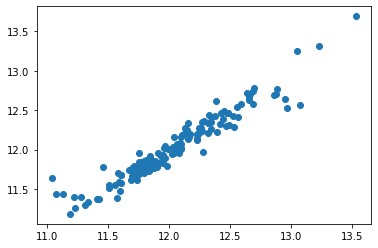

In [159]:
plt.scatter(x='actual',y='predicted',data=results)

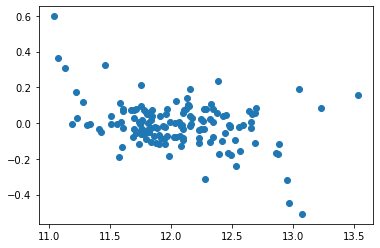

In [160]:
plt.scatter(x=results['actual'],y=results['predicted']-results['actual'])

In [164]:
pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1)

,0,1
151,GarageFinish__Unf,-0.116503
86,Neighborhood__BrkSide,-0.104697
150,GarageFinish__RFn,-0.100522
115,Exterior1st__Wd Sdng,-0.094550
137,BsmtFinType1__Unf,-0.091310
...,...,...
77,MSZoning__RL,0.092384
81,LandContour__Bnk,0.099849
16,YearBuilt_3,0.102492
129,BsmtExposure__Gd,0.109216


seems somewhat better, lower RMSE and less weird coefficients. But the residuals are still in a strange pattern. Now trying Ridge, Lasso and ElasticNet

In [106]:
model = Ridge(alpha=1.0)
scores = cross_val_score(model, train_poly_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.12244763448067975

In [107]:
model = Ridge(alpha=20,solver='auto')
scores = cross_val_score(model, train_poly_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.1184557196750741

In [108]:
model.fit(X_train, y_train)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [109]:
results = pd.DataFrame(data={'actual':y_test,'predicted':model.predict(X_test)})

In [110]:
np.sqrt(np.sum(np.square(results['actual']-results['predicted']))/results.shape[0])

0.1259466140631424

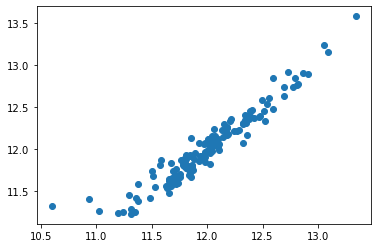

In [111]:
plt.scatter(x='actual',y='predicted',data=results)

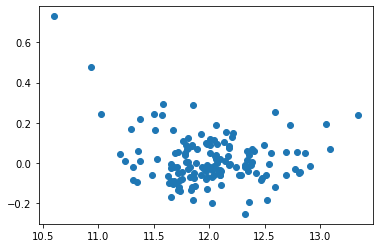

In [112]:
plt.scatter(x=results['actual'],y=results['predicted']-results['actual'])

In [113]:
pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1)

,0,1
159,SaleCondition__Abnorml,-0.043622
28,Neighborhood__NAmes GrLivArea,-0.042045
91,Neighborhood__NAmes,-0.029509
111,Exterior1st__HdBoard,-0.029399
30,LandContour__Bnk OverallQual,-0.028132
...,...,...
74,Fence__GdWo GarageArea,0.040983
187,OverallQual,0.043609
169,2ndFlrSF,0.045665
73,MasVnrType__Stone 1stFlrSF,0.052728


In [114]:
pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1).head(20)

,0,1
159,SaleCondition__Abnorml,-0.043622
28,Neighborhood__NAmes GrLivArea,-0.042045
91,Neighborhood__NAmes,-0.029509
111,Exterior1st__HdBoard,-0.029399
30,LandContour__Bnk OverallQual,-0.028132
1,LotArea_^2,-0.027472
38,1stFlrSF GrLivArea,-0.025809
79,LotShape__IR1,-0.023896
87,Neighborhood__CollgCr,-0.021625
33,Neighborhood__NAmes WoodDeckSF,-0.020995


In [115]:
pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1).tail(20)

,0,1
57,BsmtExposure__Gd 1stFlrSF,0.027685
165,YearRemodAdd,0.027874
163,LotArea,0.027923
148,GarageType__Detchd,0.028044
75,CentralAir__N 1stFlrSF,0.029916
71,BsmtFinType1__Rec OpenPorchSF,0.031120
160,SaleCondition__Normal,0.031609
99,Condition1__Norm,0.032530
121,Exterior2nd__Wd Sdng,0.033512
129,BsmtExposure__Gd,0.034457


In [116]:
model = Lasso(alpha=1.0)
scores = cross_val_score(model,  train_poly_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.3514456830262019

In [117]:
model = Lasso(alpha=0.0001,max_iter=5000,fit_intercept=True)
scores = cross_val_score(model,  train_poly_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.12035900554162293

Going to try to remove zero-ed out terms from Lasso

In [118]:
model.fit(train_poly_final_X, train_Y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=5000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [119]:
results = pd.DataFrame(data={'actual':train_Y,'predicted':model.predict(train_poly_final_X)})

In [120]:
coefs = pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1)

In [124]:
coefs.head(10)

,0,1,2
111,Exterior1st__HdBoard,-0.053091,0.053091
28,Neighborhood__NAmes GrLivArea,-0.052561,0.052561
91,Neighborhood__NAmes,-0.046311,0.046311
159,SaleCondition__Abnorml,-0.044289,0.044289
164,YearBuilt,-0.043679,0.043679
115,Exterior1st__Wd Sdng,-0.041261,0.041261
1,LotArea_^2,-0.035582,0.035582
30,LandContour__Bnk OverallQual,-0.029095,0.029095
151,GarageFinish__Unf,-0.028621,0.028621
79,LotShape__IR1,-0.027421,0.027421


In [125]:
coefs.tail(10)

,0,1,2
121,Exterior2nd__Wd Sdng,0.053888,0.053888
74,Fence__GdWo GarageArea,0.055160,0.055160
167,TotalBsmtSF,0.057027,0.057027
169,2ndFlrSF,0.058790,0.058790
73,MasVnrType__Stone 1stFlrSF,0.064922,0.064922
170,GrLivArea,0.065632,0.065632
78,MSZoning__RM,0.067519,0.067519
157,SaleType__New,0.076014,0.076014
77,MSZoning__RL,0.077087,0.077087
76,MSZoning__FV,0.090309,0.090309


In [121]:
coefs[2]=np.absolute(coefs[1])

In [122]:
zeroed_columns = coefs[coefs[2]==0][0]

In [123]:
zeroed_columns

88     Neighborhood__Crawfor
89     Neighborhood__Edwards
4      MasVnrArea_^2        
97     Neighborhood__Somerst
130    BsmtExposure__Mn     
84     LotConfig__CulDSac   
136    BsmtFinType1__Rec    
119    Exterior2nd__Plywood 
108    RoofStyle__Hip       
110    Exterior1st__CemntBd 
118    Exterior2nd__MetalSd 
114    Exterior1st__VinylSd 
128    BsmtExposure__Av     
171    GarageYrBlt          
116    Exterior2nd__CmentBd 
177    NoGarage             
141    CentralAir__N        
81     LandContour__Bnk     
154    Fence__GdPrv         
149    GarageFinish__Fin    
80     LotShape__Reg        
142    CentralAir__Y        
143    Electrical__FuseA    
146    GarageType__Attchd   
176    No2ndFloor           
138    BsmtFinType2__Rec    
178    NoEnclosedPorch      
Name: 0, dtype: object

In [128]:
train_poly_final_X_drop = train_poly_final_X.drop(zeroed_columns,axis=1)

In [129]:
model = Lasso(alpha=0.0001,max_iter=5000,fit_intercept=True)
scores = cross_val_score(model, train_poly_final_X_drop, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.11916774943971883

In [126]:
model = ElasticNet(alpha=1.0,l1_ratio=0.5)
scores = cross_val_score(model, train_poly_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.31719734348468254

In [152]:
model = ElasticNet(alpha=0.0011,l1_ratio=0.35)
scores = cross_val_score(model, train_poly_final_X, train_Y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
scores.mean()

-0.11894741040148546

In [130]:
model.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=5000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [131]:
results = pd.DataFrame(data={'actual':y_test,'predicted':model.predict(X_test)})

In [132]:
np.sqrt(np.sum(np.square(results['actual']-results['predicted']))/results.shape[0])

0.12520573365331547

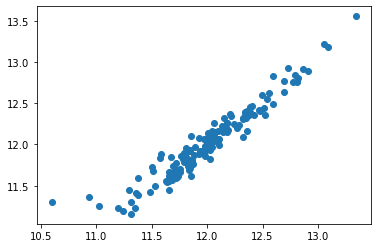

In [133]:
plt.scatter(x='actual',y='predicted',data=results)

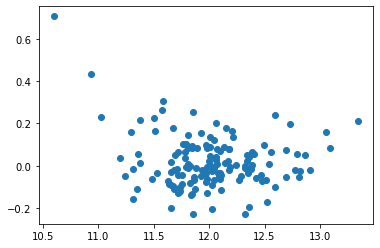

In [134]:
plt.scatter(x=results['actual'],y=results['predicted']-results['actual'])

In [135]:
pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1)

,0,1
28,Neighborhood__NAmes GrLivArea,-0.054358
111,Exterior1st__HdBoard,-0.046936
91,Neighborhood__NAmes,-0.045348
159,SaleCondition__Abnorml,-0.044772
1,LotArea_^2,-0.040915
...,...,...
170,GrLivArea,0.063406
73,MasVnrType__Stone 1stFlrSF,0.067815
77,MSZoning__RL,0.068054
76,MSZoning__FV,0.074877


In [136]:
pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1).head(20)

,0,1
28,Neighborhood__NAmes GrLivArea,-0.054358
111,Exterior1st__HdBoard,-0.046936
91,Neighborhood__NAmes,-0.045348
159,SaleCondition__Abnorml,-0.044772
1,LotArea_^2,-0.040915
79,LotShape__IR1,-0.034930
115,Exterior1st__Wd Sdng,-0.034172
164,YearBuilt,-0.034057
112,Exterior1st__MetalSd,-0.032730
30,LandContour__Bnk OverallQual,-0.030229


In [137]:
pd.DataFrame(zip(train_poly_final_X.columns, model.coef_)).sort_values(by=1).tail(20)

,0,1
75,CentralAir__N 1stFlrSF,0.040757
67,LandContour__Bnk BsmtQual,0.043295
153,PavedDrive__Y,0.043548
102,BldgType__TwnhsE,0.045013
187,OverallQual,0.045148
148,GarageType__Detchd,0.045282
69,SaleCondition__Normal LotArea,0.045900
129,BsmtExposure__Gd,0.046608
106,HouseStyle__SLvl,0.047951
78,MSZoning__RM,0.048521
